
pygame 2.5.2 (SDL 2.28.3, Python 3.11.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


1/1 [==============================] - 0s 49ms/step


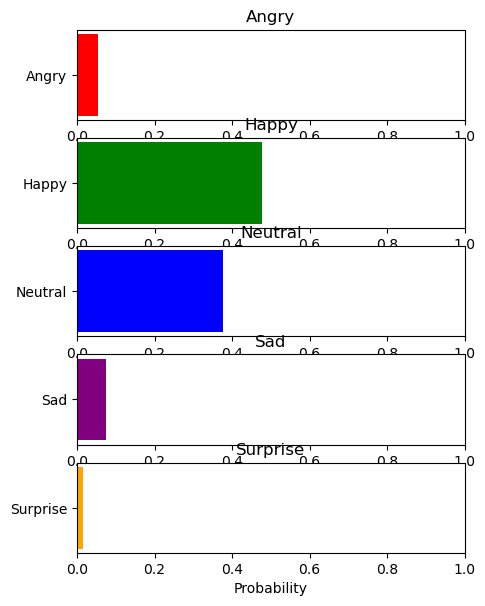

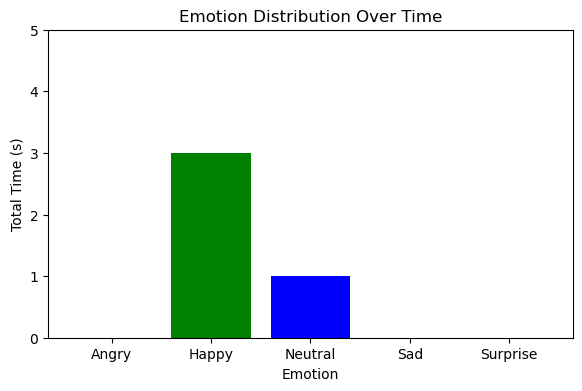

In [1]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np
import tkinter as tk
from PIL import Image, ImageTk
import pygame
import os
import time
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import ttk

# Initialize pygame mixer
pygame.mixer.init()

# Define the face cascade classifier
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the saved model
classifier = load_model('./Emotion_Detection.h5')

# Define the emotion labels and colors
class_labels = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
colors = ['red', 'green', 'blue', 'purple', 'orange']

# Initialize Tkinter window for webcam feed
window = tk.Tk()
window.title("Webcam Feed")

# Create a Tkinter label to display the video feed
panel = tk.Label(window)
panel.pack(padx=10, pady=10)

# Create a Tkinter label to display the predicted emotion
display_label = tk.Label(window, text="Emotion: None", font=("Helvetica", 16))
display_label.pack()

# Initialize Tkinter window for probability graph
graph_window = tk.Tk()
graph_window.title("Emotion Probability Graph")

# Create a frame for the probability graph
graph_frame = tk.Frame(graph_window)
graph_frame.pack(padx=11, pady=11)

# Initialize Matplotlib figure for the probabilities graph
fig, ax = plt.subplots(nrows=5, figsize=(5, 7))  # Adjust the number of rows based on the number of emotions
canvas = FigureCanvasTkAgg(fig, master=graph_frame)
canvas_widget = canvas.get_tk_widget()
canvas_widget.pack()

# # Initialize Tkinter window for song selection
# song_window = tk.Toplevel(window)
# song_window.title("Song Selection")

# # Create a label for the song selection
# song_label = tk.Label(song_window, text="Select Song for Happy:")
# song_label.pack()

# # Create a dropdown menu for song selection
# happy_songs = ['happy_song1.mp3', 'happy_song2.mp3', 'happy_song3.mp3']  # Add your songs here
# selected_happy_song = tk.StringVar(song_window)
# selected_happy_song.set(happy_songs[0])  # Set the default song
# happy_song_dropdown = ttk.Combobox(song_window, textvariable=selected_happy_song, values=happy_songs)
# happy_song_dropdown.pack()

# Initialize Tkinter window for static emotion distribution graph
static_graph_window = tk.Toplevel(window)
static_graph_window.title("Static Emotion Distribution Graph")

# Create a frame for the static emotion distribution graph
static_graph_frame = tk.Frame(static_graph_window)
static_graph_frame.pack(padx=11, pady=11)

# Initialize Matplotlib figure for the static emotion distribution
static_fig, static_ax = plt.subplots(figsize=(8, 4))
static_canvas = FigureCanvasTkAgg(static_fig, master=static_graph_frame)
static_canvas_widget = static_canvas.get_tk_widget()
static_canvas_widget.pack()

# Initialize emotion count dictionary to store the count of each emotion
emotion_count = {label: 0 for label in class_labels}

# Flag to check if the initial duration has passed
initial_duration_passed = False

# Function to update the static emotion distribution graph
def update_static_graph():
    if not initial_duration_passed:
        static_ax.clear()
        static_ax.bar(class_labels, emotion_count.values(), color=colors)
        static_ax.set_ylim([0, observation_duration])
        static_ax.set_ylabel('Total Time (s)')
        static_ax.set_xlabel('Emotion')
        static_ax.set_title('Emotion Distribution Over Time')
        static_canvas.draw()

# Function to update the Tkinter window with the probabilities graph
def update_graph(preds):
    global display_label, ax  # Declare display_label and ax as global variables
    for i, emotion in enumerate(class_labels):
        ax[i].clear()
        ax[i].barh(emotion, preds[i], color=colors[i])
        ax[i].set_xlim([0, 1])
        ax[i].set_xlabel('Probability')
        ax[i].set_title(emotion)

    canvas.draw()

# Function to update the emotion count based on the detected emotion
def update_emotion_count(emotion):
    emotion_count[emotion] += 1
    update_static_graph()

# Function to process each frame and update the GUI
def process_frame():
    global start_time, observation_duration, highest_emotion, music_playing, initial_duration_passed
    current_time = time.time()

    # Grab a single frame of video
    ret, frame = cap.read()
    labels = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.3, 5)
    
    

    # Check if any faces are detected
    if len(faces) > 0:
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

            if np.sum([roi_gray]) != 0:
                roi = roi_gray.astype('float') / 255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)

                # make a prediction on the ROI, then lookup the class
                preds = classifier.predict(roi)[0]
                label = class_labels[preds.argmax()]
                label_position = (x, y)
                cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)

                # Update the Tkinter window with the video feed
                display_label.config(text=f"Emotion: {label}")

                # Update the graph
                update_graph(preds)

                # Update the static graph and emotion count only for the initial duration
                if not initial_duration_passed:
                    update_emotion_count(label)

                # Check if the observation duration is reached
                if current_time - start_time >= observation_duration:
                    # Play music based on the detected emotion
                    play_music(label)

                    # Keep track of the highest emotion during the observation
                    highest_emotion = label

                    # Set the flag to indicate that the initial duration has passed
                    initial_duration_passed = True
    else:
        # Display the "No Face Found" message
        cv2.putText(frame, 'No Face Found', (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
        display_label.config(text="Emotion: None")

    # Display the processed frame in the Tkinter window
    photo = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    photo = Image.fromarray(photo)
    photo = ImageTk.PhotoImage(image=photo)
    panel.config(image=photo)
    panel.image = photo

    # Call the function again after a delay
    window.after(10, process_frame)


# Function to play music based on the detected emotion
def play_music(emotion):
    global music_playing

    # Define the path to the music files
    music_folder = './music'

    # Map emotions to corresponding music files
    music_mapping = {
        'Angry': 'angry_music.mp3',
#         'Happy': selected_happy_song.get(),  
        'Happy': 'happy_song1.mp3',
        'Neutral': 'neutral_music.mp3',
        'Sad': 'sad_music.mp3',
        'Surprise': 'surprise_music.mp3',
    }

    # Get the corresponding music file for the detected emotion
    music_file = music_mapping.get(emotion)

    if music_file:
        # Join the music folder path and music file name
        music_path = os.path.join(music_folder, music_file)

        # Check if music is currently playing
        if not music_playing:
            # Play the music
            pygame.mixer.music.load(music_path)
            pygame.mixer.music.play()
            music_playing = True

        # Check if the music has finished playing
        elif not pygame.mixer.music.get_busy():
            # Restart the music
            pygame.mixer.music.play()

# Open a connection to the camera (camera index 0 by default)
cap = cv2.VideoCapture(0)

# Set the observation duration (in seconds)
observation_duration = 5
start_time = time.time()

# Variable to keep track of the highest emotion during observation
highest_emotion = None

# Variable to track whether music is currently playing
music_playing = False

# Start processing frames for the webcam feed
window.after(10, process_frame)

# Start Tkinter main loop for all windows
window.mainloop()
